In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('C:\\Users\\Mikhail\\Documents\\Data 606')
import final_cleanup
%matplotlib inline

In [2]:
data = final_cleanup.data_clean()

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017624 entries, 0 to 1048571
Data columns (total 49 columns):
TMC                      1017624 non-null int64
Severity                 1017624 non-null int64
Start_Time               1017624 non-null datetime64[ns]
End_Time                 1017624 non-null datetime64[ns]
Start_Lat                1017624 non-null float64
Start_Lng                1017624 non-null float64
Distance(mi)             1017624 non-null float64
Description              1017624 non-null object
Street                   1017624 non-null object
Side                     1017624 non-null int64
City                     1017624 non-null object
County                   1017624 non-null object
State                    1017624 non-null object
Zipcode                  1017624 non-null object
Timezone                 1017624 non-null int64
Temperature(F)           1017624 non-null float64
Humidity(%)              1017624 non-null float64
Pressure(in)             1017624 non-

In [3]:
#Seeing which TMC codes are represented and finding out what they mean
sorted(data['TMC'].unique())

[200,
 201,
 202,
 203,
 206,
 222,
 229,
 236,
 239,
 241,
 244,
 245,
 246,
 247,
 248,
 336,
 339,
 341,
 343,
 351,
 406]

In [4]:
#Getting rid of likely faulty temperature readings from suggestion of the creator of the dataset
def temp_keeper(df):
    df = df[(df['Temperature(F)'] >= -4) & (data['Temperature(F)'] <= 106)]
    
    return df

f_data = temp_keeper(data.copy())

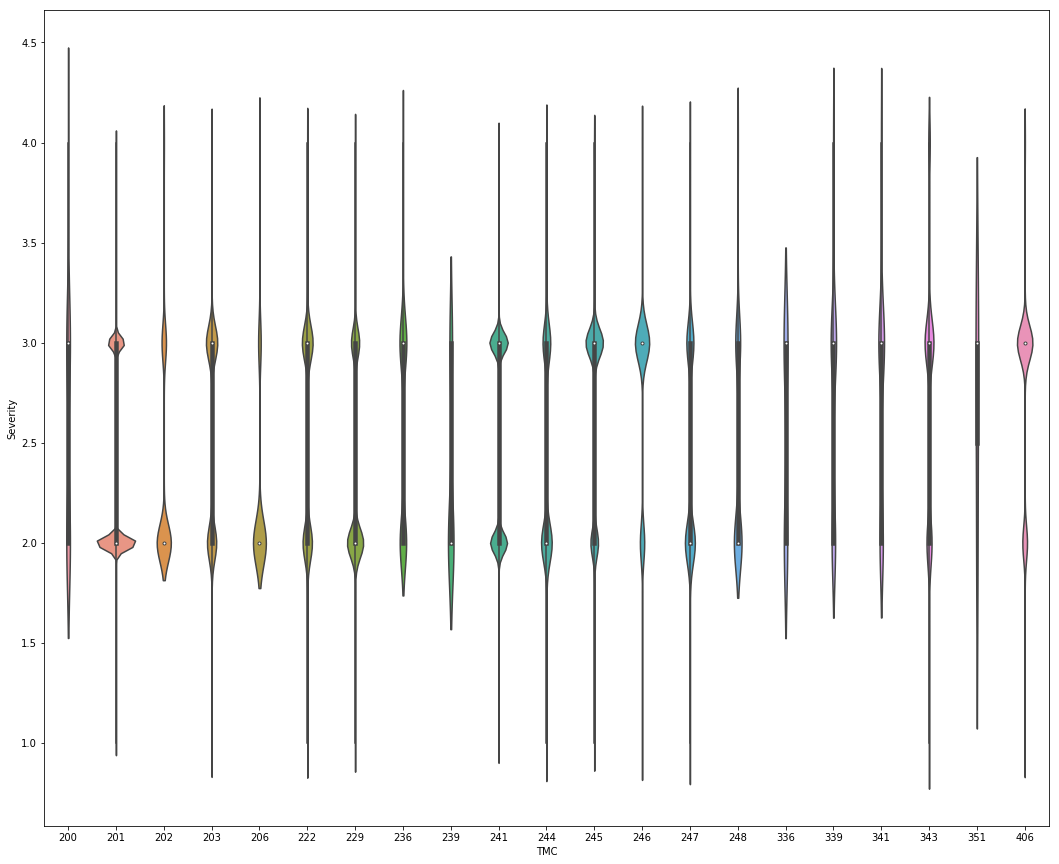

In [5]:
#Exploring relationship between code and severity
sns.violinplot(x = 'TMC', y = 'Severity', data = f_data)
fig = plt.gcf()
fig.set_size_inches(18,15)

In [6]:
"""
Encoding different road types. Types are county, state highway, us numbered highway, and interstate highway. Normal roads are not being
encoded to leave out 1 dummy variable.
"""
def road_encoder(df):

    df['State_Hwy'] = 0
    df['Numbered_Hwy'] = 0
    df['County_Hwy'] = 0
    df.rename({'Highway' : 'Interstate_Hwy'}, axis = 1, inplace = True)
    
    
    df.loc[df['Description'].str.contains(r'accident on us-\d'), 'Numbered_Hwy'] = 1
    df.loc[df['Description'].str.contains(r'accident on [^i^us]{2}-\d'), 'State_Hwy'] = 1
    df.loc[df['Description'].str.contains(r'accident on county hwy-\d'), 'County_Hwy'] = 1
    
    return df

f_data_enc = road_encoder(f_data)

TMC Codes:

200 - multi vehicle pile up. Delays

201 - accident(s)

202 - serious accident(s)

203 - multi-vehicle accident

206 - fuel spillage accident(s)

222 - accident(s). Queuing traffic

229 - accident(s). Slow traffic

236 - accident(s). Heavy traffic

239 - accident(s). Traffic building up

241 - accident(s). Right lane blocked

244 - accident(s). Hard shoulder blocked

245 - accident(s). Two lanes blocked

246 - accident(s). Three lanes blocked

247 - accident. Delays

248 - accident. Delays expected

336 - oil spillage accident(s)

339 - jackknifed trailer(s)

341 - jackknifed articulated lorr(y/ies)

343 - earlier accident(s)

351 - accident(s) in roadworks area

406 - entry slip road closed

In [13]:
"""
Pulling information from descriptions to include accident details. Descriptions are more reliable encoders of accidents details 
than TMC codes.
"""
def acc_encoder(df):
    
    df['multi_vehicle'] = 0
    df.loc[df['Description'].str.contains('multi-vehicle'), 'multi_vehicle'] = 1
    
    df['serious'] = 0
    df.loc[df['Description'].str.contains('serious accident'), 'serious'] = 1
    
    df['spillage'] = 0
    df.loc[df['Description'].str.contains(r'fuel|oil spillage'), 'spillage'] = 1
    
    df['construction_area'] = 0
    df.loc[df['Description'].str.contains('construction area'), 'construction_area'] = 1
    
    df['road_blocked'] = 0
    df.loc[df['Description'].str.contains(r'lane|lanes|shoulder|partially blocked'), 'road_blocked'] = 1
    
    df['jacknifed'] = 0
    df.loc[df['Description'].str.contains('jacknifed'), 'jacknifed'] = 1
    
    df['ramp_blocked'] = 0
    df.loc[df['Description'].str.contains('entry ramp closed'), 'ramp_blocked'] = 1
    
    return df

f_data_enc = acc_encoder(f_data_enc)

In [14]:
def percent_severe():
    ones = len(f_data_enc[f_data_enc['Severity'] == 1])
    twos = len(f_data_enc[f_data_enc['Severity'] == 2])
    threes = len(f_data_enc[f_data_enc['Severity'] == 3])
    fours = len(f_data_enc[f_data_enc['Severity'] == 4])
    
    print('{}% of crashes are at a 1 severity\n'.format(ones / len(f_data_enc) * 100))
    print('{}% of crashes are at a 2 severity\n'.format(twos / len(f_data_enc) * 100))
    print('{}% of crashes are at a 3 severity\n'.format(threes / len(f_data_enc) * 100))
    print('{}% of crashes are at a 4 severity\n'.format(fours / len(f_data_enc) * 100))
    
percent_severe()

0.05145237359735714% of crashes are at a 1 severity

66.48423865243971% of crashes are at a 2 severity

33.11024187534556% of crashes are at a 3 severity

0.35406709861737734% of crashes are at a 4 severity



Far less than 1% of accidents are either a 1 or 4 for severity, this creates a scenario where my main class of interest is a small minority. Options include combining these severities and approaching this as a binary classification problem, which may be 
an option as severity has no specific definition or methodology outlined for it. For now I will leave it as a multiclassification task and attempt to attain a satisfactory performance.

In [15]:
#Writing prepped datasets for analysis to csv
arkansas = f_data_enc[f_data_enc['State'] == 'AR']
wv = f_data_enc[f_data_enc['State'] == 'WV']

arkansas.to_csv('C:\\Users\\Mikhail\\Documents\\Data 606\\ark_crashes.csv')
wv.to_csv('C:\\Users\\Mikhail\\Documents\\Data 606\\wv_crashes.csv')
f_data_enc.to_csv('C:\\Users\\Mikhail\\Documents\\Data 606\\cleaned_data.csv')